In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt

## Positional Encoding and the Embedding layer

- The paper uses **fixed positional embeddings** using **sine and cosine** functions.
- The positional encodings have the same dimension as the embeddings.
- We can also have **learned embeddings for position** but the paper uses the sinusoidal version because they claim that it may allow the model to **extrapolate** to sequence lengths **longer** than the ones encountered during training.


$$
\text{PE}(pos, 2i) = \sin\left(\frac{pos}{{10000^{(2i/d_{\text{model}})}}}\right)
$$

$$
\text{PE}(pos, 2i+1) = \cos\left(\frac{pos}{{10000^{(2i/d_{\text{model}})}}}\right)
$$

### Here's what some of the terms in the above equations mean

$\boldsymbol{pos}$ - position of the token in the sequence.<br>
$\boldsymbol{i}$ - dimension index. Each dimension of PE corresponds to a sinusoid.<br>
$\boldsymbol{d_\text{model}}$ - dimension of the word embeddings.

In [2]:
class PositionalEncoding(nn.Module):
    """
    Calculate positional encodings using sine and cosine functions (fixed embeddings).
    """
    def __init__(self, d_model, dropout_prob=0.1, max_seq_len=5000):
        """
        Parameters:
        d_model - dimension of the word embeddings.
        max_seq_len - maximum sequence length of input.
        """
        super().__init__()
        self.dropout = nn.Dropout(p=dropout_prob)
        
        # (The paper states): The wavelengths of sinusoids form a geometric progression from 2π to 10000 · 2π
        # pos shape -> (max_seq_len, 1)
        # div_term shape -> (d_model/2,) => We have d_model number of sinusoids counting both sine and cosine
        # pos * div_term shape -> (max_seq_len, d_model/2)
        pos = torch.arange(0, max_seq_len).unsqueeze(1)
        div_term = torch.pow(10000., -torch.arange(0, d_model, 2, dtype=torch.float) / d_model)
        
        # We take values from the same domain point from each sinusoid for a particular word 
        # The number of sinusoids we sample from is equal to the embedding size
        # We alternate between sin and cosine sinusoids to represent the embedding
        # positional_encoding_table shape -> (max_seq_len, d_model) 
        positional_encodings_table = torch.zeros(max_seq_len, d_model)
        positional_encodings_table[:, 0::2] = torch.sin(pos * div_term) # sin at even positions
        positional_encodings_table[:, 1::2] = torch.cos(pos * div_term) # cos at odd positions
        
        # Positional encodings need to be saved in the model's state_dict
        # positional_encodings_table is not a trainable parameter and would be excluded otherwise
        self.register_buffer('positional_encodings_table', positional_encodings_table)
    
    def forward(self, batch_of_embeddings):
        # Add the learned semantic embeddings with positional embeddings
        # Clip positional encoding table according to sequence len of semantic embeddings (of input)
        combined_embeddings = batch_of_embeddings + self.positional_encodings_table[:batch_of_embeddings.shape[1]]
        
        # (The paper states): We apply dropout to the sums of the embeddings and the positional encodings 
        return self.dropout(combined_embeddings)

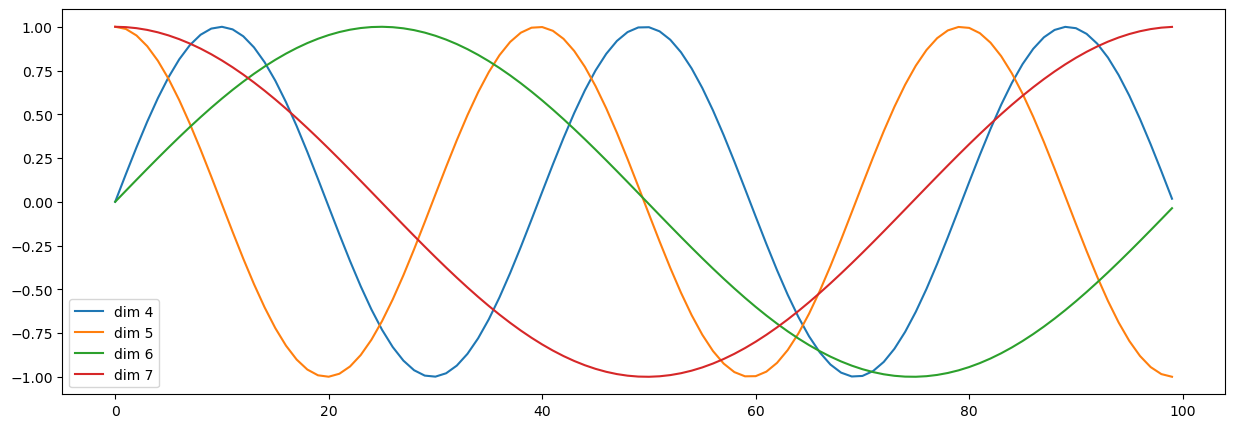

In [3]:
# Ideas taken from https://nlp.seas.harvard.edu/2018/04/03/attention.html#batches-and-masking
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(d_model=20, dropout_prob=0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))

# Plot the output after adding semantic and positional embeddings along with dropour
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
plt.show()

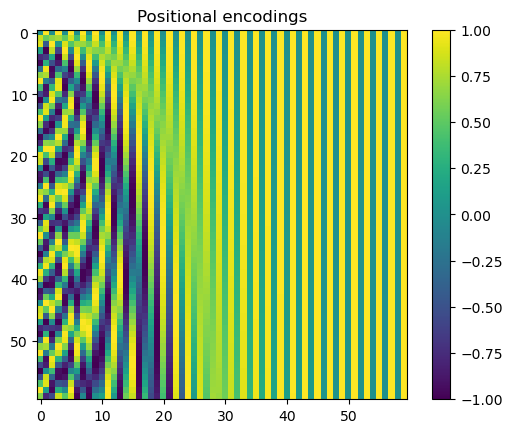

In [4]:
# Idea for visualization taken from https://jalammar.github.io/illustrated-transformer/
def visualize_positional_encodings(embed_dim, seq_len):
    pe = PositionalEncoding(d_model=embed_dim, dropout_prob=0.1)
    
     # Extract the positional encodings table
    positional_encodings_table = pe.positional_encodings_table.numpy()
    
    plt.figure()
    plt.title('Positional encodings')
    plt.imshow(positional_encodings_table[:seq_len])
    plt.colorbar()
    plt.show()

# plot of size (seq_len, embed_dim). Choose equal coordinates for better visualization(square)  
visualize_positional_encodings(embed_dim=60, seq_len=60)

In [5]:
class Embedding(nn.Module):
    """
    Learned embeddings to convert input and output tokens to vectors.
    Both the input and output embedding layers share weight matrix.
    """
    def __init__(self, embed_dim, vocab_size):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        self.embed_dim = embed_dim
        
    def forward(self, batch_of_tokens):
        assert batch_of_tokens.ndim == 2, f'Expected: (batch size, max token sequence length), got {token_ids_batch.shape}'
        
        # (The paper states): In the embedding layers, we multiply those weights by √dmodel.
        # Page 5, Chapter 3.4 "Embeddings and Softmax"
        # d_model is the same as embed_dimension in our case
        embeddings = self.embeddings(batch_of_tokens)
        return embeddings * math.sqrt(self.embed_dim)